# Image Classification
This project classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. The images will be preprocess, then a convolutional neural network will be trained with all the samples. The images need to be normalized and the labels need to be one-hot encoded. 
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/cifar/cifar-10-python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 8:
Image - Min Value: 31 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


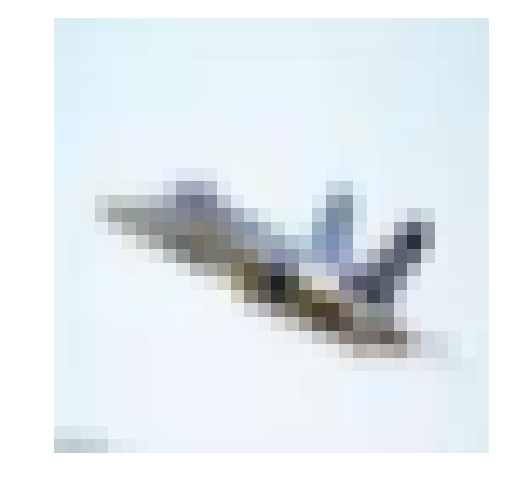

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

batch_id = 2
sample_id = 8
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    normalized_x = np.zeros(tuple(x.shape))
    nr_images = x.shape[0]
    max_value, min_value = x.max(), x.min()

    for image_index in range(nr_images):
        normalized_x[image_index,...] = (x[image_index, ...] - float(min_value)) / float(max_value - min_value)    
    return normalized_x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
The input, `x`, are a list of labels. The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.

In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(10)    
    one_hot_encoded_labels = encoder.fit_transform(np.array(x).reshape(-1, 1)).toarray()
    return one_hot_encoded_labels


tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples is already randomized.

## Preprocess all the data and save it
The code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
The preprocessed data has been saved to disk.

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. 
These names will be used at the end of the project to load the saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=((None,) + image_shape), name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=(None, n_classes), name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, shape=(None), name='keep_prob')



tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. 

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weights_shape = list(conv_ksize) + [x_tensor.get_shape().as_list()[3], conv_num_outputs]
    weights = tf.Variable(tf.truncated_normal(weights_shape, stddev=5e-2))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    output = tf.nn.conv2d(x_tensor, weights, 
                          strides=[1, conv_strides[0], conv_strides[1], 1],
                          padding='SAME')
    output = tf.nn.bias_add(output, bias)
    output = tf.nn.relu(output)
    
    output = tf.nn.max_pool(output, 
                            ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                            strides=[1, pool_strides[0], pool_strides[1], 1],
                            padding='SAME')                                  
    return output


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.contrib.layers.flatten(x_tensor)


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer

In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    return tf.layers.dense(x_tensor, num_outputs, activation=tf.nn.relu)  



tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    return tf.layers.dense(x_tensor, num_outputs)


tests.test_output(output)

Tests Passed


### Create Convolutional Model
The function `conv_net` create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.

In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv = conv2d_maxpool(x,
                           conv_num_outputs=64,
                           conv_ksize=[5,5],
                           conv_strides=[1,1],
                           pool_ksize=[3,3],
                           pool_strides=[2,2]) # 14x14x64
    conv = tf.layers.dropout(conv, rate=keep_prob)
    conv = conv2d_maxpool(conv,
                          conv_num_outputs=64,
                          conv_ksize=[5,5],
                          conv_strides=[1,1],
                          pool_ksize=[3,3],
                          pool_strides=[2,2]) # 7x7x64
    conv = tf.layers.dropout(conv, rate=keep_prob)
        
    # Function Definition from Above:
    #   flatten(x_tensor)
    flattened_conv = flatten(conv)
    
    
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fc = fully_conn(flattened_conv, 384)
    fc = fully_conn(fc, 192)
    
    
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    fc = output(fc, 10)
    
    return fc      



##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
The function `train_neural_network` to do a single optimization. 
This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x: feature_batch,
                                      y: label_batch,
                                      keep_prob: keep_probability})


tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
The function `print_stats` print loss and validation accuracy.

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = sess.run(cost, feed_dict={x: feature_batch,
                                     y: label_batch,
                                     keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={x: valid_features,
                                              y: valid_labels,
                                              keep_prob: 1.})

    print('Loss: {:>10.4f} Accuracy: {:.6f}'.format(loss, valid_acc))

### Hyperparameters

In [17]:
epochs = 50
batch_size = 8192 # Set batch_size to the highest number that your machine has memory for: 64, 128, 256...
keep_probability = 0.7

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [18]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.3154 Accuracy: 0.105000
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.2545 Accuracy: 0.156000
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.1907 Accuracy: 0.243600
Epoch  4, CIFAR-10 Batch 1:  Loss:     2.0756 Accuracy: 0.251800
Epoch  5, CIFAR-10 Batch 1:  Loss:     2.0792 Accuracy: 0.264600
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.9137 Accuracy: 0.311000
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.8590 Accuracy: 0.341600
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.8131 Accuracy: 0.343200
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.7733 Accuracy: 0.342600
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.7241 Accuracy: 0.353400
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.6642 Accuracy: 0.387200
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.6094 Accuracy: 0.386200
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.5594 Accuracy: 0.404200
Epoch 14, CIFAR-10 Batch 1:  Loss:     1.5724 Accuracy: 0.394600
Epoch 15, CIFAR-10 Batch 1:  Loss:     1.5043 A

### Fully Train the Model

In [19]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2720 Accuracy: 0.162000
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.2380 Accuracy: 0.215600
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.1585 Accuracy: 0.228000
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.0087 Accuracy: 0.264800
Epoch  1, CIFAR-10 Batch 5:  Loss:     2.2584 Accuracy: 0.188200
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.1457 Accuracy: 0.235800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.9713 Accuracy: 0.282400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.8977 Accuracy: 0.281600
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.8225 Accuracy: 0.310600
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.8463 Accuracy: 0.316000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.8035 Accuracy: 0.349400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.7478 Accuracy: 0.346200
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.6847 Accuracy: 0.363600
Epoch  3, CIFAR-10 Batch 4:  Loss:     1.6249 Accuracy: 0.398200
Epoch  3, CIFAR-10 Batch 5:  Loss:     1.6719 Accuracy: 0.402200
Epoch  4, CIF

Epoch 26, CIFAR-10 Batch 2:  Loss:     0.4434 Accuracy: 0.638800
Epoch 26, CIFAR-10 Batch 3:  Loss:     0.4035 Accuracy: 0.652400
Epoch 26, CIFAR-10 Batch 4:  Loss:     0.3785 Accuracy: 0.651400
Epoch 26, CIFAR-10 Batch 5:  Loss:     0.3944 Accuracy: 0.631000
Epoch 27, CIFAR-10 Batch 1:  Loss:     0.4198 Accuracy: 0.652600
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.4237 Accuracy: 0.637400
Epoch 27, CIFAR-10 Batch 3:  Loss:     0.4526 Accuracy: 0.622000
Epoch 27, CIFAR-10 Batch 4:  Loss:     0.4441 Accuracy: 0.615800
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.4119 Accuracy: 0.636800
Epoch 28, CIFAR-10 Batch 1:  Loss:     0.4361 Accuracy: 0.629000
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.4481 Accuracy: 0.635800
Epoch 28, CIFAR-10 Batch 3:  Loss:     0.3964 Accuracy: 0.643000
Epoch 28, CIFAR-10 Batch 4:  Loss:     0.3801 Accuracy: 0.648600
Epoch 28, CIFAR-10 Batch 5:  Loss:     0.3633 Accuracy: 0.646800
Epoch 29, CIFAR-10 Batch 1:  Loss:     0.3753 Accuracy: 0.645400
Epoch 29, CIFAR-10 Batch 

# Checkpoint

## Test Model
The accuracy should have greater than 50%.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6622287333011627



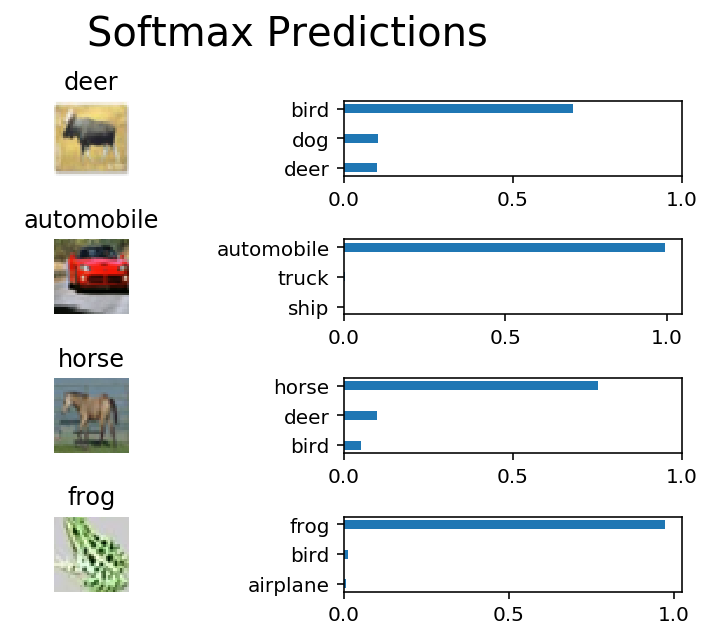

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

###### Why 66% Accuracy?
You might be wondering why can't get an accuracy any higher. First things first, 50% or 60% isn't bad for a simple CNN. Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.